# Import

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## Data Cleaning and Visualization of Badminton Data

This notebook demonstrates the process of cleaning and visualizing badminton data using Python and pandas. The dataset consists of two CSV files: `badmintondata.csv` and `badmintondata2.csv`. The goal is to combine the datasets, clean the data, and generate a 3D scatterplot for visualization.

### Data Loading and Cleaning

- The first step is to load the data from the CSV files using pandas' `read_csv` function.
- Missing values are handled by dropping rows with missing values using the `dropna` method.
- Outliers are identified and removed using the z-score method. Rows with z-scores exceeding a certain threshold are considered outliers and filtered out.
- Inconsistencies in the data, such as decimal separators, are addressed by replacing commas with periods and converting the data to float format.

### Data Combination

- The two datasets, `badmintondata.csv` and `badmintondata2.csv`, are combined into a single dataframe using pandas' `concat` function.

### Data Visualization

- A 3D scatterplot is generated to visualize the badminton data.
- Two scatterplots are shown side by side:
  - Cleaned Combined Dataset: The dataset after cleaning, with outliers removed and inconsistencies addressed.
  - Uncleaned Combined Dataset: The dataset before cleaning, with outliers and inconsistencies present.
- The scatterplots provide insights into the distribution and patterns of the data in three-dimensional space.


Number of rows before cleaning: 315200
Number of rows after cleaning: 168842


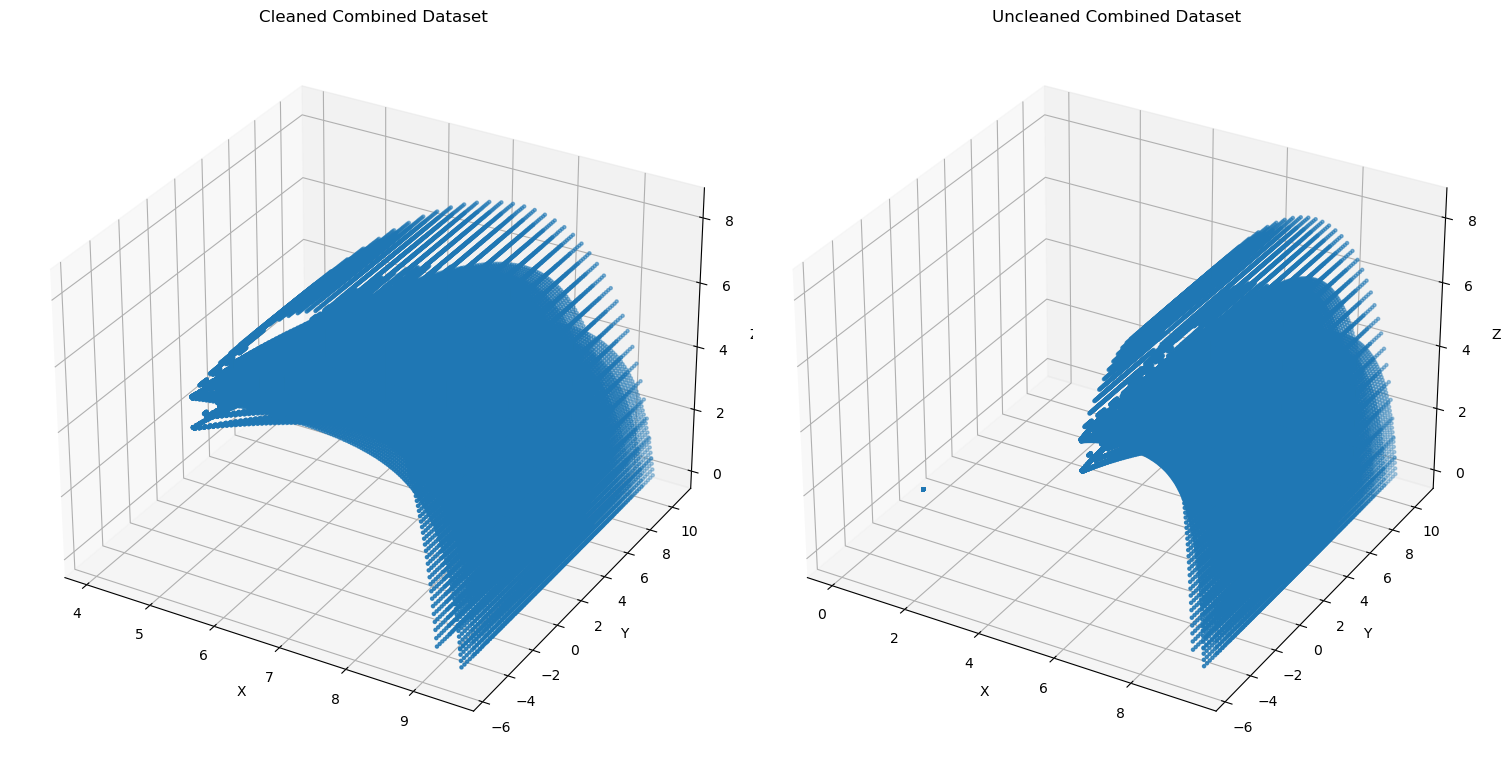

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the first dataset
df1 = pd.read_csv('badmintondata.csv')

# Load the second dataset
df2 = pd.read_csv('badmintondata2.csv')

# Combine both datasets
df_combined = pd.concat([df1, df2], ignore_index=True)

# Count rows before cleaning
rows_before_cleaning = df_combined.shape[0]

# Handling missing values
df_combined = df_combined.dropna()  # Drop rows with missing values

# Handling outliers (Using z-score)
z_scores_combined = (df_combined - df_combined.mean()) / df_combined.std()  # Calculate z-scores
threshold = 3  # Set a threshold for outliers
outliers_combined = (z_scores_combined.abs() > threshold).any(axis=1)  # Find rows with outliers
df_combined_cleaned = df_combined[~outliers_combined].copy()  # Filter out rows with outliers

# Identify consecutive rows of all zeros
mask = (df_combined == 0).all(axis=1)
groups = mask.cumsum()

# Filter out consecutive rows of all zeros
df_combined_cleaned = df_combined[~mask]
df_combined_cleaned.to_csv('cleaned_dataset.csv', index = False)

# Count rows after cleaning
rows_after_cleaning = df_combined_cleaned.shape[0]

print("Number of rows before cleaning:", rows_before_cleaning)
print("Number of rows after cleaning:", rows_after_cleaning)

# Generate scatterplot for the cleaned combined dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Cleaned Combined Dataset
axes[0].scatter(df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_zlabel('Z')
axes[0].set_title('Cleaned Combined Dataset')
axes[0].grid(True)

# Uncleaned Combined Dataset
axes[1].scatter(df_combined['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_zlabel('Z')
axes[1].set_title('Uncleaned Combined Dataset')
axes[1].grid(True)

plt.tight_layout()
plt.show()


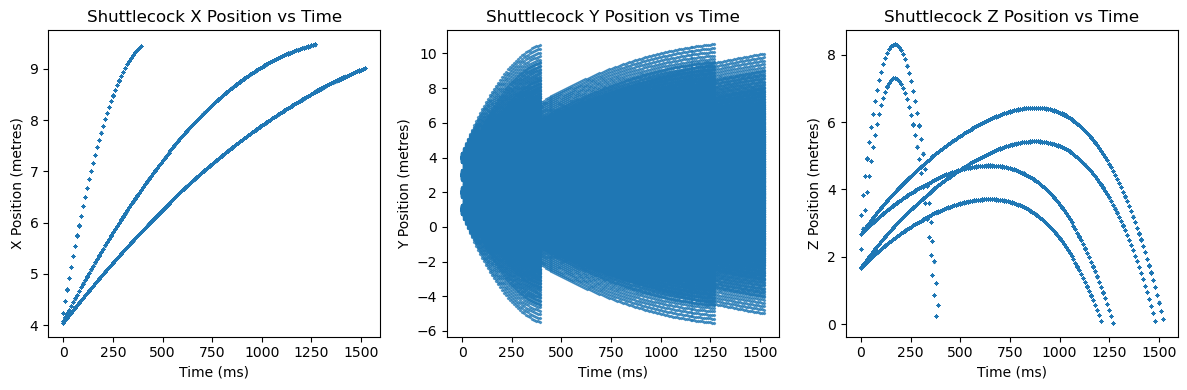

In [57]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups, group_keys=False)

# Function to add a Time field to a group
def add_time_field(group):
    group['TIME'] = np.arange(len(group)) * 10  # Multiply by 10 to get time in ms
    return group

grouped_df = grouped_df.apply(add_time_field)

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the X position vs Time
axs[0].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(X) metres'], marker='x', s=2, alpha=0.8)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('X Position (metres)')
axs[0].set_title('Shuttlecock X Position vs Time')

# Plot the Y position vs Time
axs[1].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(Y) metres'], marker='x', s=2, alpha=0.8)
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Y Position (metres)')
axs[1].set_title('Shuttlecock Y Position vs Time')

# Plot the Z position vs Time
axs[2].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(Z) metres'], marker='x', s=2, alpha=0.8)
axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Z Position (metres)')
axs[2].set_title('Shuttlecock Z Position vs Time')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [58]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups)

# Split the groups into testing set and sample set (split into a testing set and a sample set using a 70:30 ratio)
train_groups, test_groups = train_test_split(list(grouped_df.groups), test_size=0.3, random_state=42)

# Create the training set
train_df = pd.concat([grouped_df.get_group(group) for group in train_groups])

# Create the testing set
test_df = pd.concat([grouped_df.get_group(group) for group in test_groups])

# Apply a TIME-based transformation to each group in the train and test data
train_df = train_df.groupby(groups, group_keys=False).apply(add_time_field)
test_df = test_df.groupby(groups, group_keys=False).apply(add_time_field)

In [59]:
# Define the non-feature columns
non_feature_cols = ["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres",
                    "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
                    "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "TIME"]

# Define the feature columns
feature_cols = ["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres",
                "SHUTTLECOCK POSITIION IN AIR(Z) metres"]

# Create the training feature DataFrame
train_features = train_df[feature_cols].copy()

# Create the training non-feature DataFrame
train_non_features = train_df[non_feature_cols].copy()

# Create the testing feature DataFrame
test_features = test_df[feature_cols].copy()

# Create the testing non-feature DataFrame
test_non_features = test_df[non_feature_cols].copy()

# Display the training feature DataFrame
print("Training Features:")
print(train_features.head())

# Display the training non-feature DataFrame
print("\nTraining Non-Features:")
print(train_non_features.head())

# Display the testing feature DataFrame
print("\nTesting Features:")
print(test_features.head())

# Display the testing non-feature DataFrame
print("\nTesting Non-Features:")
print(test_non_features.head())


Training Features:
        SHUTTLECOCK POSITIION IN AIR(X) metres  \
155400                                4.049012   
155401                                4.099699   
155402                                4.148521   
155403                                4.198738   
155404                                4.246939   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
155400                                0.957395   
155401                                0.913333   
155402                                0.870893   
155403                                0.827240   
155404                                0.785339   

        SHUTTLECOCK POSITIION IN AIR(Z) metres  
155400                                2.685690  
155401                                2.770077  
155402                                2.854290  
155403                                2.934386  
155404                                3.012884  

Training Non-Features:
        HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITI

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
main_non_feature_cols = ["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres",
                    "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
                    "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "TIME", "SHUTTLECOCK POSITIION IN AIR(Z) metres" ]


def getModelString(name, coefficients ,intercept) :
    # This model is for x and y only , cause they will have a fixed z value they wanna predict from
    modelStr = ''
    for index,(feature, coef) in enumerate(zip(main_non_feature_cols, coefficients)):
        modelStr += str(coef)+" X"+ str(index+1) + " + "
    
    return name+" : "+modelStr + str(intercept)

# Extract features and target variables

X_train = train_df[main_non_feature_cols].copy()
X_train_for_z = train_df[non_feature_cols].copy()

y_side_train = train_features["SHUTTLECOCK POSITIION IN AIR(X) metres"].to_list()
y_forward_train = train_features["SHUTTLECOCK POSITIION IN AIR(Y) metres"].to_list()

# Create polynomial features
poly = PolynomialFeatures(degree=6)
X_train_poly = poly.fit_transform(X_train)

reg_side = LinearRegression()
reg_side.fit(X_train_poly, y_side_train)

reg_forward = LinearRegression()
reg_forward.fit(X_train_poly, y_forward_train)

# Evaluate regression models on the training set
y_side_train_pred = reg_side.predict(X_train_poly)
y_forward_train_pred = reg_forward.predict(X_train_poly)

mse_side_train = mean_squared_error(y_side_train, y_side_train_pred)
mse_forward_train = mean_squared_error(y_forward_train, y_forward_train_pred)

mae1_train= mean_absolute_error(y_side_train, y_side_train_pred)
mae2_train= mean_absolute_error(y_forward_train, y_forward_train_pred)

r2_score_side_train = r2_score(y_side_train, y_side_train_pred)
r2_score_forward_train = r2_score(y_forward_train, y_forward_train_pred)

print("X predictor on training:")
print(getModelString('  X Model' ,reg_side.coef_,reg_side.intercept_ ))
print("  RMSE:", mse_side_train)
print("  MAE:", mae1_train)
print("  R-squared on Train:", r2_score_side_train)

print("Y predictor on training:")
print(getModelString('  Y Model' ,reg_forward.coef_,reg_forward.intercept_ ))
print("  MSE:", mse_forward_train)
print("  MAE:", mae2_train)
print("  R-squared:", r2_score_forward_train)

# Evaluate regression models on the test set
X_test = test_df[main_non_feature_cols].copy()
y_side_test = test_features["SHUTTLECOCK POSITIION IN AIR(X) metres"]
y_forward_test = test_features["SHUTTLECOCK POSITIION IN AIR(Y) metres"]

X_test_poly = poly.transform(X_test)
y_side_test_pred = reg_side.predict(X_test_poly)
y_forward_test_pred = reg_forward.predict(X_test_poly)

mse_side_test = mean_squared_error(y_side_test, y_side_test_pred)
mse_forward_test = mean_squared_error(y_forward_test, y_forward_test_pred)

mae1_test= mean_absolute_error(y_side_test, y_side_test_pred)
mae2_test= mean_absolute_error(y_forward_test, y_forward_test_pred)

r2_score_side_test = r2_score(y_side_test, y_side_test_pred)
r2_score_forward_test = r2_score(y_forward_test, y_forward_test_pred)


print("X predictor on test:")
print("  RMSE:", mse_side_test)
print("  MAE:", mae1_test)
print("  R-squared:", r2_score_side_test)

print("Y predictor on test:")
print("  RMSE:", mse_forward_test)
print("  MAE:", mae2_test)
print("  R-squared:", r2_score_forward_test)



X predictor on training:
  X Model : -2.7557695698508505e-09 X1 + -9.170693721381296e-10 X2 + 2.750484373349564e-11 X3 + -5.088712240367062e-11 X4 + 1.0104767917868187e-11 X5 + 2.8095249997850425e-12 X6 + -3.719867575787856e-12 X7 + 4.0791576091396164
  RMSE: 9.955193232118602e-07
  MAE: 0.0007960701934422947
  R-squared on Train: 0.999999582189177
Y predictor on training:
  Y Model : 2.718613292987027e-08 X1 + 5.229706419559205e-09 X2 + -1.002445985336366e-09 X3 + -1.507754189291922e-10 X4 + -6.542873644124731e-10 X5 + -5.842520119605094e-12 X6 + 8.582530609507209e-11 X7 + 0.012146156445228318
  MSE: 6.422779746053187e-06
  MAE: 0.001615278582985697
  R-squared: 0.9999987185313169
X predictor on test:
  RMSE: 9.96798948991186e-07
  MAE: 0.0007966864252318831
  R-squared: 0.9999995843381024
Y predictor on test:
  RMSE: 9.498156071423463e-06
  MAE: 0.00176767522026106
  R-squared: 0.9999981337610394


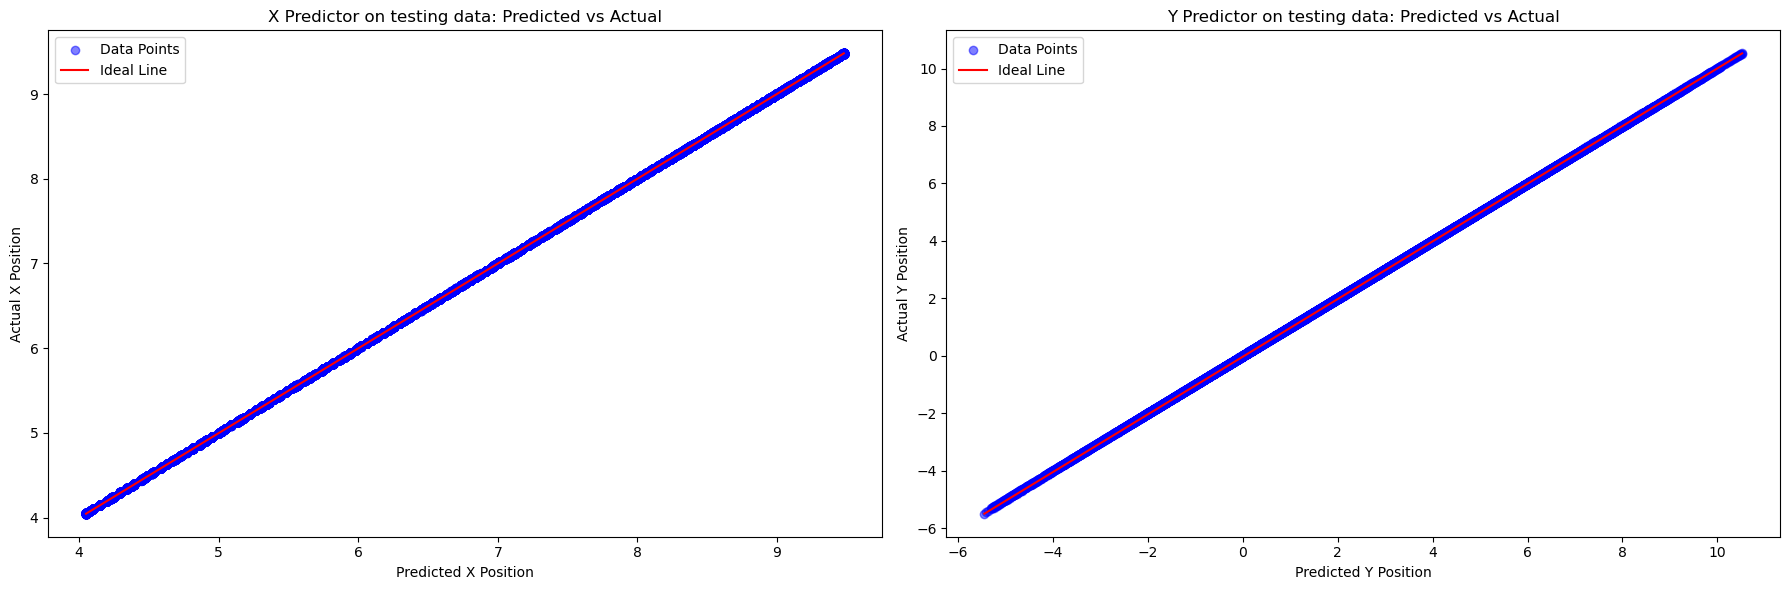

In [61]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Visualize predicted vs actual values for X predictor
axes[0].scatter(y_side_test_pred, y_side_test, color='blue', alpha=0.5, label='Data Points')
axes[0].plot([min(y_side_test_pred), max(y_side_test_pred)], [min(y_side_test), max(y_side_test)], color='red', label='Ideal Line')
axes[0].set_xlabel('Predicted X Position')
axes[0].set_ylabel('Actual X Position')
axes[0].set_title('X Predictor on testing data: Predicted vs Actual')
axes[0].legend()

# Visualize predicted vs actual values for Y predictor
axes[1].scatter(y_forward_test_pred, y_forward_test, color='blue', alpha=0.5, label='Data Points')
axes[1].plot([min(y_forward_test_pred), max(y_forward_test_pred)], [min(y_forward_test), max(y_forward_test)], color='red', label='Ideal Line')
axes[1].set_xlabel('Predicted Y Position')
axes[1].set_ylabel('Actual Y Position')
axes[1].set_title('Y Predictor on testing data: Predicted vs Actual')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


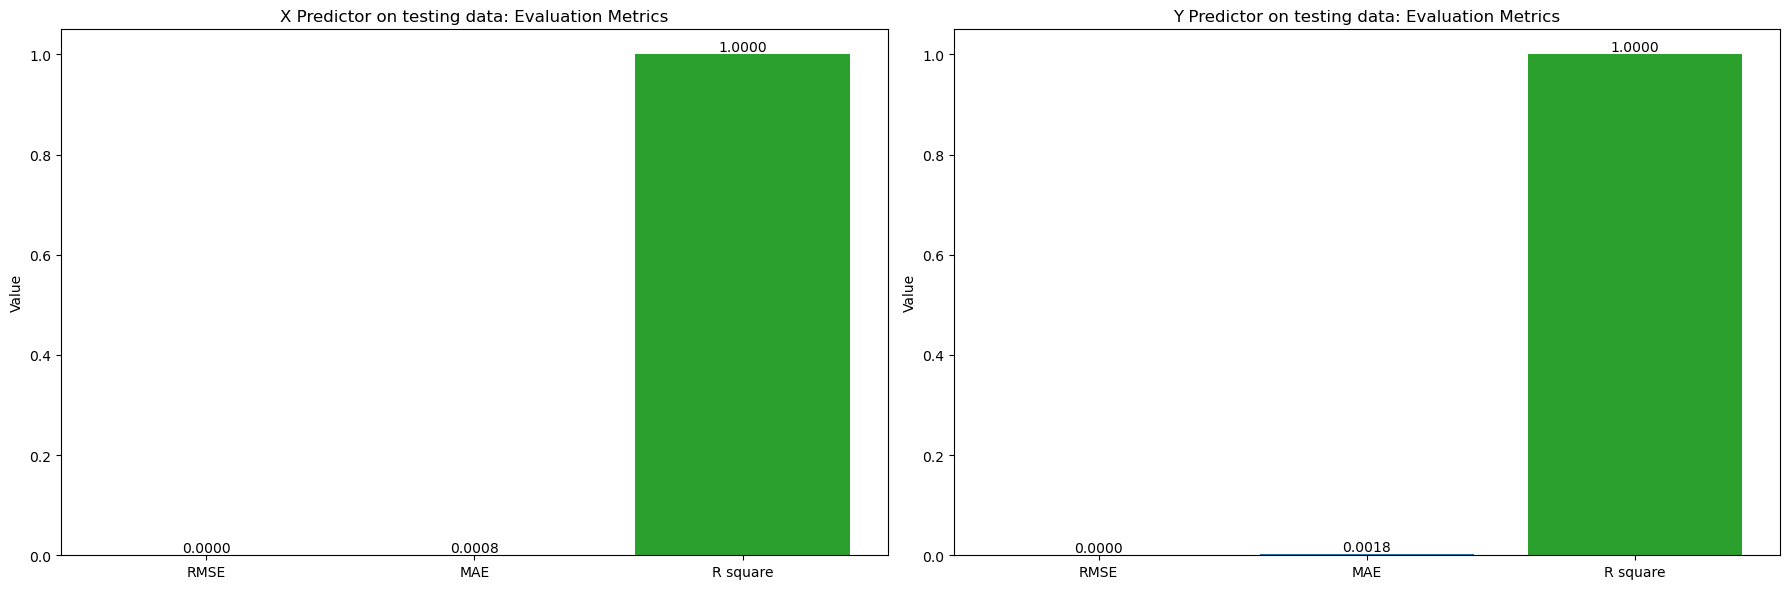

In [62]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Evaluation metric names
metrics = ['RMSE', 'MAE', 'R square']


# Evaluation metric values for X predictor
values_x = [mse_side_test, mae1_test, r2_score_side_test]

# Evaluation metric values for Y predictor
values_y = [mse_forward_test, mae2_test, r2_score_forward_test]

# Colors for the bars
colors = ['#FF7F0E', '#1F77B4', '#2CA02C']


# Visualize evaluation metrics for X predictor
axes[0].bar(metrics, values_x, color=colors)
axes[0].set_title('X Predictor on testing data: Evaluation Metrics')
axes[0].set_ylabel('Value')

# Add data labels to the bars in X predictor subplot
for i, v in enumerate(values_x):
    axes[0].text(i, v, f"{v:.4f}", ha='center', va='bottom')

# Visualize evaluation metrics for Y predictor
axes[1].bar(metrics, values_y, color=colors)
axes[1].set_title('Y Predictor on testing data: Evaluation Metrics')
axes[1].set_ylabel('Value')

# Add data labels to the bars in Y predictor subplot
for i, v in enumerate(values_y):
    axes[1].text(i, v, f"{v:.4f}", ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### Predicting X and Y to a fix value of Z (0.8323 meter) as optimal height

In [64]:
import numpy as np

dummyData = """
4	1	10	40	0	1.662911962
4	1	10	40	0	1.72486637
4	1	10	40	0	1.788139098
4	1	10	40	0	1.845244983
4	1	10	40	0	1.904127726
4	1	10	40	0	1.962541187
4	1	10	40	0	2.018857335
4	1	10	40	0	2.071654009
4	1	10	40	0	2.127861644
4	1	10	40	0	2.178635753
4	1	10	40	0	2.233492954
4	1	10	40	0	2.28340222
4	1	10	40	0	2.332455057
4	1	10	40	0	2.379732739
4	1	10	40	0	2.430622608
4	1	10	40	0	2.475123289
4	1	10	40	0	2.522975118
4	1	10	40	0	2.565753026
4	1	10	40	0	2.608968419
4	1	10	40	0	2.653999671
4	1	10	40	0	2.694693412
4	1	10	40	0	2.736440902
4	1	10	40	0	2.777969097
4	1	10	40	0	2.816387675
4	1	10	40	0	2.856549264
4	1	10	40	0	2.894873788
4	1	10	40	0	2.931634222
4	1	10	40	0	2.967813503
4	1	10	40	0	3.00229617
4	1	10	40	0	3.037646513
4	1	10	40	0	3.071123013
4	1	10	40	0	3.104296564
4	1	10	40	0	3.136480762
4	1	10	40	0	3.170356064
4	1	10	40	0	3.200093494
4	1	10	40	0	3.228748951
4	1	10	40	0	3.258815171
4	1	10	40	0	3.288896296
4	1	10	40	0	3.315348236
4	1	10	40	0	3.342570654
4	1	10	40	0	3.369862986
4	1	10	40	0	3.392916604
4	1	10	40	0	3.418027204
4	1	10	40	0	3.442182052
4	1	10	40	0	3.462081522
4	1	10	40	0	3.486002737
4	1	10	40	0	3.504532151
4	1	10	40	0	3.524526313
4	1	10	40	0	3.543596794
4	1	10	40	0	3.564259625
4	1	10	40	0	3.580330713
4	1	10	40	0	3.596466385
4	1	10	40	0	3.612633423
4	1	10	40	0	3.624884021
4	1	10	40	0	3.637442719
4	1	10	40	0	3.651028645
4	1	10	40	0	3.66281677
4	1	10	40	0	3.670795919
4	1	10	40	0	3.680116652
4	1	10	40	0	3.689246186
4	1	10	40	0	3.695125529
4	1	10	40	0	3.698971408
4	1	10	40	0	3.704279934
4	1	10	40	0	3.707068057
"""

rows = dummyData.strip().split('\n')
arr = np.array([row.split('\t') for row in rows], dtype=float)

# As we know that the first 5 column is the same we will shown with a fix value of y as shown , we pick the first arr which is [0] 
# We also want to find the fix z value at 0.8323 hence is inside and also there assume we successfully get the correct timing 

poly_true_data =poly.transform([[arr[0][0],arr[0][1],arr[0][2],arr[0][3],arr[0][4],1150, 0.8323 ]])

# [0] because is will only be one dimension as we only put in one dimension
predictedXValue = reg_side.predict(poly_true_data)[0]
predictedYValue = reg_forward.predict(poly_true_data)[0]
print("It is predicted that the shuttercork will be falling at the coordinate ( " ,predictedXValue," , ",predictedYValue," ) when Z is 0.8323 meter")


It is predicted that the shuttercork will be falling at the coordinate (  9.331892953848492  ,  1.0028288907011123  ) when Z is 0.8323 meter


c:\Users\dougl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
